In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

np.random.seed(42)

In [ ]:
ma2 = np.array([1, 0.9, 0.3])
ar2 = np.array([1, 0, 0])

MA2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

<Axes: >

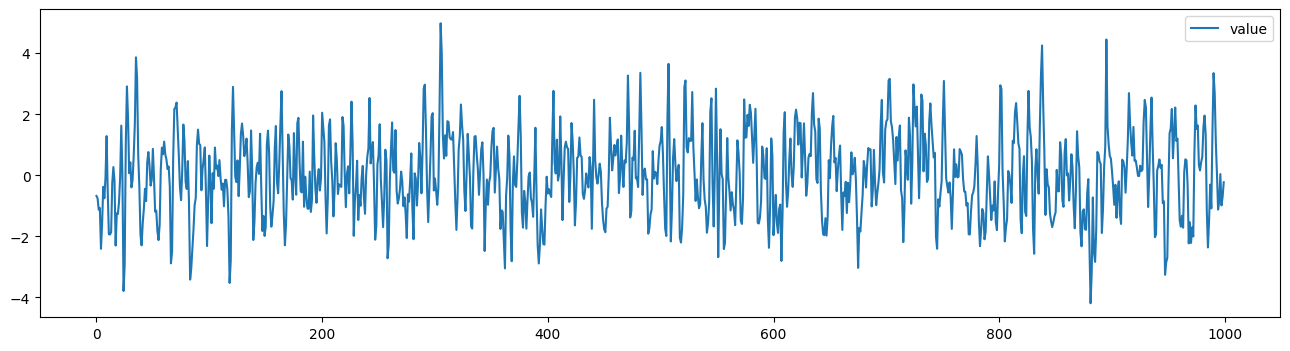

In [36]:
df = pd.DataFrame({'value': MA2_process})
df.plot( figsize=(16,4),  layout='constrained')

In [10]:
ADF_result = adfuller(MA2_process)
ADF_result

(-14.654592269469111,
 3.457386112953022e-27,
 2,
 997,
 {'1%': -3.4369259442540416,
  '5%': -2.8644432969122833,
  '10%': -2.5683158550174094},
 2747.404912777615)

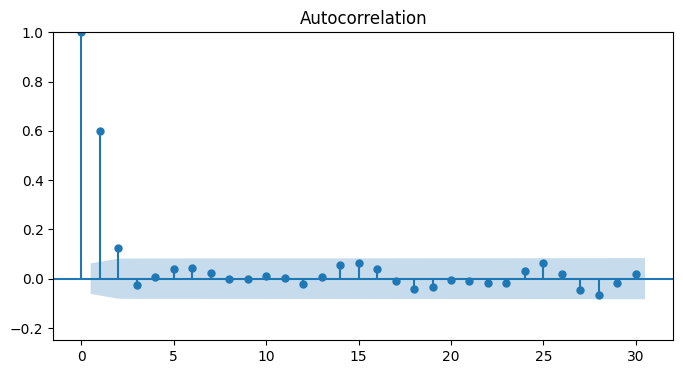

In [96]:
fig, ax = plt.subplots( figsize=(8,4) )
plot_acf(MA2_process, lags=30, ax=ax)
plt.ylim(-0.25, 1)
plt.show()

In [62]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        return pred_MA

In [ ]:
train = df[:800]
test = df[800:]


TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA2 = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'MA')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_MA2'] = pred_MA2

test.head()

<Axes: >

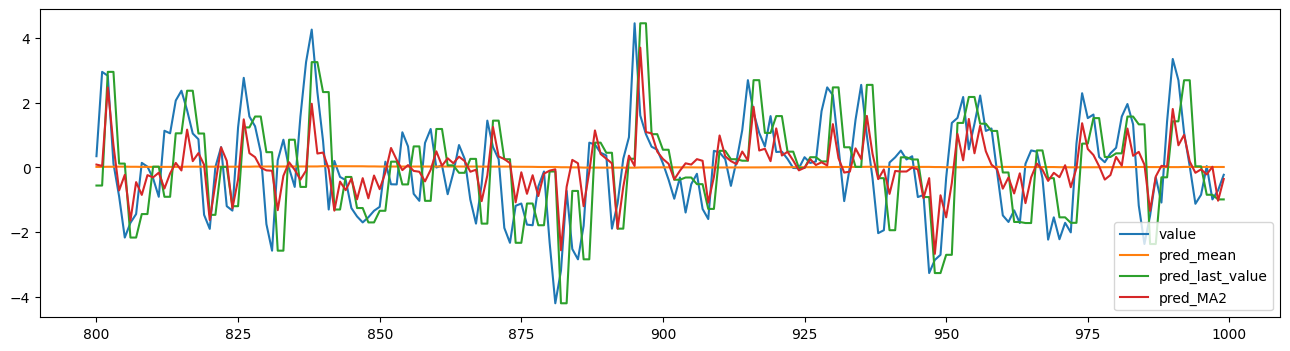

In [57]:
test.plot(figsize=(16,4), layout='constrained')

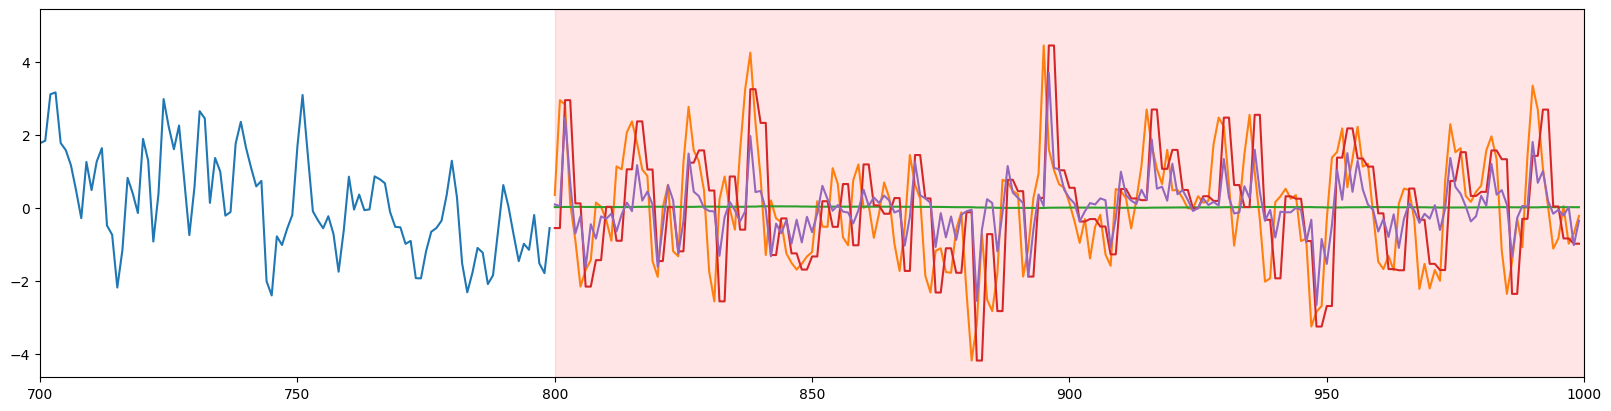

In [58]:
fig, ax = plt.subplots(figsize=(16,4), layout='constrained')
ax.plot(train)
ax.plot(test)
ax.axvspan(800, 1000, color='red', alpha=0.1)
plt.xlim(700, 1000)
plt.show()

In [59]:
import torch
from torch import nn
mse = nn.MSELoss()
loss = {}

In [60]:
loss['mean'] =  mse( torch.FloatTensor( test['pred_mean'][:].values),  torch.FloatTensor(test['value'][:].values) ).item()
loss['last_value'] = mse( torch.FloatTensor( test['pred_last_value'][:].values),  torch.FloatTensor(test['value'][:].values) ).item()
loss['MA'] =  mse( torch.FloatTensor( test['pred_MA2'][:].values),  torch.FloatTensor(test['value'][:].values) ).item()
loss

{'mean': 2.1775407791137695,
 'last_value': 2.482553005218506,
 'MA': 1.5431387424468994}

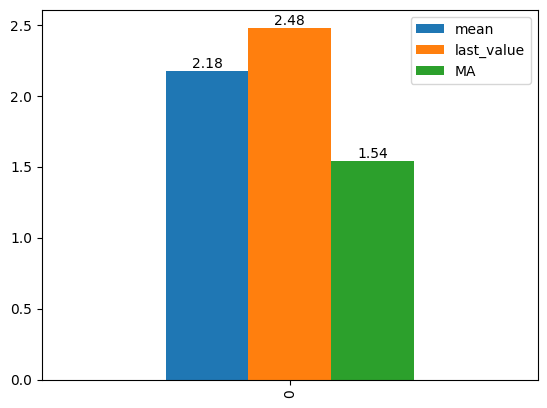

In [61]:
ax =  pd.DataFrame([loss]).plot.bar()
for index, label in enumerate(loss):   
    ax.bar_label(ax.containers[index], fmt='%.2f',  fontsize=10)

In [63]:
ma3 = np.array([1, 0.9, 0.3, 0.2])
ar3 = np.array([1, 0, 0, 0])

MA3_process = ArmaProcess(ar3, ma3).generate_sample(nsample=10000)

<Axes: >

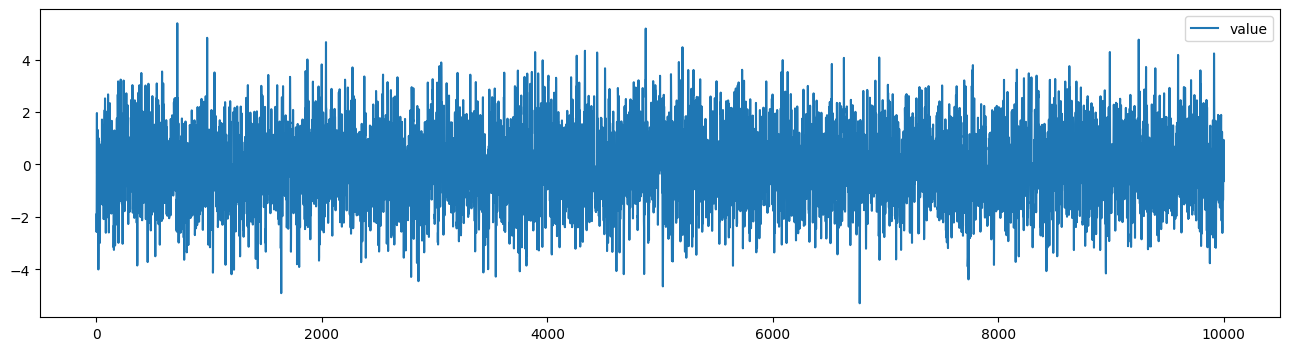

In [64]:
df = pd.DataFrame({'value': MA3_process})
df.plot( figsize=(16,4),  layout='constrained')

In [65]:
ADF_result = adfuller(MA3_process)
ADF_result

(-21.28965986731691,
 0.0,
 19,
 9980,
 {'1%': -3.431005409094333,
  '5%': -2.8618296517685877,
  '10%': -2.566924176499291},
 28326.98369443577)

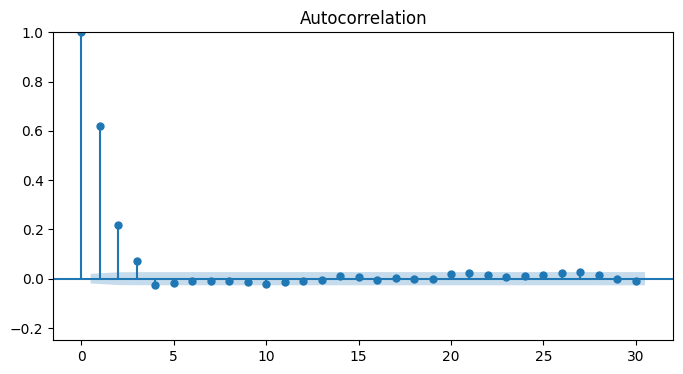

In [99]:
fig, ax = plt.subplots( figsize=(8,4) )
plot_acf(MA3_process, lags=30, ax=ax)
plt.ylim(-0.25, 1)
plt.show()

In [69]:
MA3_train = df[:-200]
MA3_test = d[-200:]

In [ ]:
TRAIN_LEN = len(MA3_train)
HORIZON = len(MA3_test)
WINDOW = 3

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA3 = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'MA')

MA3_test['pred_mean'] = pred_mean[:200]
MA3_test['pred_last_value'] = pred_last_value[:200]
MA3_test['pred_MA3'] = pred_MA3[:200] 

MA3_test.head()

<Axes: >

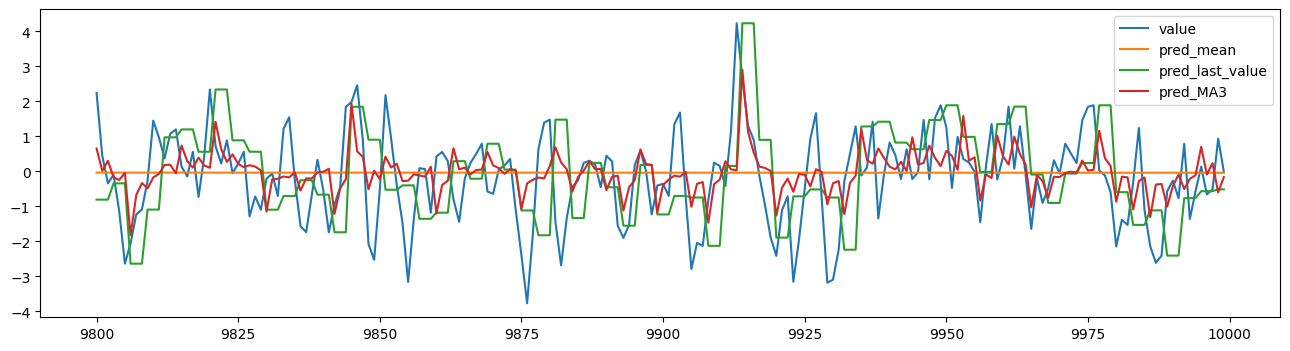

In [71]:
MA3_test.plot(figsize=(16,4), layout='constrained')

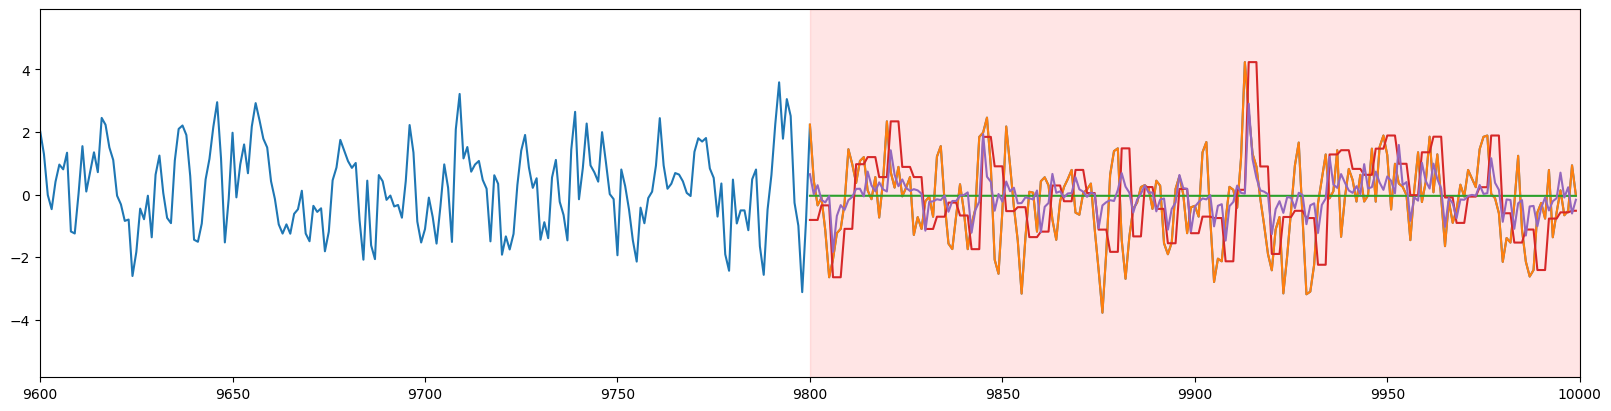

In [80]:
fig, ax = plt.subplots(figsize=(16,4), layout='constrained')
ax.plot(df)
ax.plot(MA3_test)
ax.axvspan(9800, 10000, color='red', alpha=0.1)
plt.xlim(9600, 10000)
plt.show()

In [83]:
loss = {}
loss['mean'] =  mse( torch.FloatTensor( MA3_test['pred_mean'][:].values),  torch.FloatTensor(MA3_test['value'][:].values) ).item()
loss['last_value'] = mse( torch.FloatTensor( MA3_test['pred_last_value'][:].values),  torch.FloatTensor(MA3_test['value'][:].values) ).item()
loss['MA3'] =  mse( torch.FloatTensor( MA3_test['pred_MA3'][:].values),  torch.FloatTensor(MA3_test['value'][:].values) ).item()
loss

{'mean': 1.6822079420089722,
 'last_value': 2.4295334815979004,
 'MA3': 1.405928611755371}

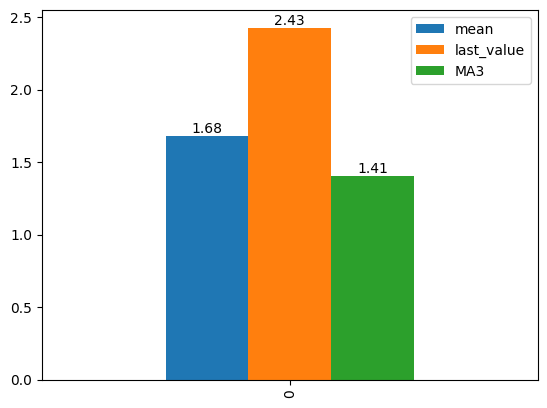

In [84]:
ax =  pd.DataFrame([loss]).plot.bar()
for index, label in enumerate(loss):   
    ax.bar_label(ax.containers[index], fmt='%.2f',  fontsize=10)